In [12]:
import os
import itertools
import json
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List, Tuple, Dict, Set

## utility functions

In [15]:
def initialize_components(component_num: int) -> Tuple[str]:
    stack = []
    alphabet = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ') * int(np.ceil(component_num/26))
    for n in range(component_num):
        it = int(np.floor(n/26))
        stack.append('{}.{}'.format(alphabet[n], it+1))
    return tuple(stack)

def aggregate_episode_samples(df):
    agg_samples = []
    episodes = df.episode.unique()
    for e in episodes:
        single_episode_samples = df[df['episode'] == e]
        
        concat_trajectories = ''
        reward_sum = 0
        for _, row in single_episode_samples.iterrows():
            source = row.source
            action = row.action
            target = row.target
            reward_sum += row.reward
            
            concat_trajectories += '\{{}->{}->{}\}], '.format(source, action, target)
        agg_samples.append({
            'episode': e,
            'trajectories': concat_trajectories,
            'reward_sum': reward_sum,
            'reward_mean':  reward_sum / len(single_episode_samples)
        })
        
    agg_samples_df = pd.DataFrame(agg_samples)
    return agg_samples_df

## Markov Chain

In [16]:
class MarkovChain:
    def __init__(self):
        self.seen_states: Set = set()
        self.states: List[Dict] = []
        self.links: List[Dict] = []
        self.unhandled_permutations = []
        self.action_reward_map = {
            'swap': -2.0,
            'repair': -1.0,
            'end': 0
        }

    def __permutate(self, state: Tuple[str]) -> Dict:
        permutations = [tuple(perm) for perm in itertools.permutations(state)]
        return {'source': state, 'permutations': permutations}

    def __repair(self, state: Tuple[str]) -> Tuple[str]:
        temp_state = list(state)
        temp_state.pop(0)
        return tuple(temp_state)

    def __deduplicate(self, l: List[Dict]) -> List[Dict]:
        #return list(li for li, _ in itertools.groupby(obj_list))
        return [dict(t) for t in {tuple(d.items()) for d in l}]

    def reset(self) -> None:
        self.seen_states = set()
        self.states = []
        self.links = []
        self.unhandled_permutations = []

    def create(self, component_tuple: Tuple[str]) -> None:
        self.reset()
        self.unhandled_permutations.append(self.__permutate(component_list))
        while len(self.unhandled_permutations) > 0:
            for i, permutated_obj in enumerate(self.unhandled_permutations):
                source_state: List[str] = list(permutated_obj['source'])
                permutation_states: List[List[str]] = list(permutated_obj['permutations'])

                if len(source_state) > 0:
                    # process source state
                    repaired_source = self.__repair(source_state)

                    self.states.append({'name': tuple(source_state)})
                    if len(source_state) == 1:
                        self.links.append({'source': tuple(source_state),
                                           'action': 'end',
                                           'target': tuple(source_state),
                                           'probability': 1 / len(permutation_states),
                                           'reward': self.action_reward_map['end']
                                          })
                    else:
                        self.links.append({'source': tuple(source_state),
                                           'action': 'repair',
                                           'target': tuple(repaired_source),
                                           'probability': 1 / len(permutation_states),
                                           'reward': self.action_reward_map['repair']
                                          })

                    repaired_source_permutations = self.__permutate(repaired_source)
                    self.unhandled_permutations.append(repaired_source_permutations)

                    for permutated_state in permutation_states[1:]:
                        self.seen_states.add(tuple(permutated_state))
                        
                        self.states.append({'name': tuple(permutated_state)})
                        self.links.append({'source': tuple(source_state),
                                           'action': 'swap',
                                           'target': tuple(permutated_state),
                                           'probability': 1 / len(permutation_states),
                                           'reward': self.action_reward_map['swap']
                                          })

                        repaired_permutated_state = self.__repair(permutated_state)
                        repaired_permutated_state_permutations = self.__permutate(repaired_permutated_state)
                        self.unhandled_permutations.append(repaired_permutated_state_permutations)
                        
                        permutated_state_permutations = self.__permutate(permutated_state)
                        permutated_state_permutations['permutations'] = [perm for perm in permutated_state_permutations['permutations'] if tuple(perm) not in self.seen_states]
                        
                        if len(permutated_state_permutations['permutations']) > 0:
                            self.unhandled_permutations.append(permutated_state_permutations)
                
                self.seen_states.add(tuple(source_state))
                self.unhandled_permutations.remove(permutated_obj)
        self.states = self.__deduplicate(self.states)
        self.links = self.__deduplicate(self.links)
        self.create_transition_matrix()
        self.create_action_space()
        
    def create_transition_matrix(self) -> pd.DataFrame:
        state_names = [str(state['name']) for state in self.states]
        self.transition_matrix = pd.DataFrame(np.zeros((len(state_names), len(state_names))))
        self.transition_matrix.index = state_names
        self.transition_matrix.columns = state_names
        
        for link in self.links:
            row = str(link['source'])
            col = str(link['target'])
            val = link['probability']
    
            self.transition_matrix.loc[row, col] = val
        
        return self.transition_matrix
    
    def create_action_space(self) -> pd.DataFrame:
        links = []
        for link in list(self.links):
            link['source'] = str(link['source'])
            link['target'] = str(link['target'])
            links.append(link)
        self.action_space = pd.DataFrame(links)
        
        return self.action_space
        
    def to_json(self, state_file_path='states.json', link_file_path='links.json') -> None:
        print('Dump states...')
        with open(state_file_path, 'w') as f:
            json.dump(self.states, f)
        
        print('Dump links...')
        with open(link_file_path, 'w') as f:
            json.dump(self.links, f)
        
        print('Done!')
        
    def set_action_reward_map(self, action_reward_map: Dict) -> None:
        self.action_reward_map = action_reward_map
        for link in self.links:
            link['reward'] =  self.action_reward_map[link['action']]
        
        self.create_action_space()
        
    def sample(self, source_state: str, episodes: int):
        samples = []
        for i in range(episodes):
            self.make_action(source_state, i, samples)
        
        return pd.DataFrame(samples)
            
        
    def make_action(self, source_state: str, episode: int, l: List):
        possible_actions = self.action_space[self.action_space['source'] == source_state]
        taken_action = possible_actions.sample(1, weights=possible_actions.probability).iloc[0]
        taken_action['episode'] = episode
        l.append(taken_action)

        target_state = taken_action.target
        reward = taken_action.reward

        if reward == 0:
            return
        else:
            self.make_action(target_state, episode, l)

In [4]:
components = initialize_components(3)
components

('A.1', 'B.1', 'C.1')

In [5]:
mcp = MarkovChain()
mcp.create(components)

## Transition Matrix

In [6]:
mcp.create_transition_matrix()

,"('C.1', 'B.1')","('B.1',)","('C.1', 'A.1')","('B.1', 'C.1')","('B.1', 'C.1', 'A.1')","('B.1', 'A.1', 'C.1')","('C.1',)","('A.1', 'C.1', 'B.1')","('C.1', 'A.1', 'B.1')","('A.1', 'B.1')","('A.1', 'B.1', 'C.1')","('C.1', 'B.1', 'A.1')","('B.1', 'A.1')","('A.1', 'C.1')","('A.1',)"
"('C.1', 'B.1')",0.0,0.5,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0
"('B.1',)",0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0
"('C.1', 'A.1')",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.50,1.0
"('B.1', 'C.1')",0.5,0.0,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0
"('B.1', 'C.1', 'A.1')",0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.0,0.333333,0.000000,0.0,0.00,0.0
"('B.1', 'A.1', 'C.1')",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.0,0.250000,0.250000,0.0,0.25,0.0
"('C.1',)",0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.0
"('A.1', 'C.1', 'B.1')",0.2,0.0,0.000000,0.000000,0.200000,0.200000,0.0,0.000000,0.200000,0.0,0.000000,0.200000,0.0,0.00,0.0
"('C.1', 'A.1', 'B.1')",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.5,0.500000,0.000000,0.0,0.00,0.0
"('A.1', 'B.1')",0.0,0.5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.5,0.00,0.0


## Action Space

In [7]:
mcp.create_action_space()

,source,action,target,probability,reward
0,"('B.1', 'C.1')",repair,"('C.1',)",1.000000,-1.0
1,"('A.1', 'B.1')",repair,"('B.1',)",0.500000,-1.0
2,"('A.1',)",end,"('A.1',)",1.000000,0.0
3,"('C.1', 'A.1', 'B.1')",swap,"('A.1', 'B.1', 'C.1')",0.500000,-2.0
4,"('A.1', 'C.1', 'B.1')",repair,"('C.1', 'B.1')",0.200000,-1.0
5,"('A.1', 'C.1', 'B.1')",swap,"('C.1', 'B.1', 'A.1')",0.200000,-2.0
6,"('C.1', 'B.1')",swap,"('B.1', 'C.1')",0.500000,-2.0
7,"('A.1', 'B.1')",swap,"('B.1', 'A.1')",0.500000,-2.0
8,"('C.1', 'B.1', 'A.1')",repair,"('B.1', 'A.1')",1.000000,-1.0
9,"('B.1', 'A.1', 'C.1')",repair,"('A.1', 'C.1')",0.250000,-1.0


## Sampling

In [8]:
samples = mcp.sample(str(components), 100)
samples

,source,action,target,probability,reward,episode
25,"('A.1', 'B.1', 'C.1')",swap,"('A.1', 'C.1', 'B.1')",0.166667,-2.0,0
15,"('A.1', 'C.1', 'B.1')",swap,"('B.1', 'A.1', 'C.1')",0.200000,-2.0,0
9,"('B.1', 'A.1', 'C.1')",repair,"('A.1', 'C.1')",0.250000,-1.0,0
21,"('A.1', 'C.1')",swap,"('C.1', 'A.1')",0.500000,-2.0,0
10,"('C.1', 'A.1')",repair,"('A.1',)",0.500000,-1.0,0
...,...,...,...,...,...,...
8,"('C.1', 'B.1', 'A.1')",repair,"('B.1', 'A.1')",1.000000,-1.0,99
13,"('B.1', 'A.1')",swap,"('A.1', 'B.1')",0.500000,-2.0,99
7,"('A.1', 'B.1')",swap,"('B.1', 'A.1')",0.500000,-2.0,99
17,"('B.1', 'A.1')",repair,"('A.1',)",1.000000,-1.0,99


## Aggregated Samples

In [9]:
agg_samples = aggregate_episode_samples(samples)
agg_samples

,episode,trajectories,reward_sum,reward_mean
0,0,"[('A.1', 'B.1', 'C.1')->swap->('A.1', 'C.1', '...",-8.0,-1.333333
1,1,"[('A.1', 'B.1', 'C.1')->swap->('C.1', 'B.1', '...",-4.0,-1.000000
2,2,"[('A.1', 'B.1', 'C.1')->swap->('B.1', 'A.1', '...",-16.0,-1.600000
3,3,"[('A.1', 'B.1', 'C.1')->swap->('B.1', 'C.1', '...",-4.0,-1.000000
4,4,"[('A.1', 'B.1', 'C.1')->swap->('C.1', 'A.1', '...",-16.0,-1.600000
...,...,...,...,...
95,95,"[('A.1', 'B.1', 'C.1')->repair->('B.1', 'C.1')...",-2.0,-0.666667
96,96,"[('A.1', 'B.1', 'C.1')->repair->('B.1', 'C.1')...",-2.0,-0.666667
97,97,"[('A.1', 'B.1', 'C.1')->swap->('B.1', 'C.1', '...",-10.0,-1.428571
98,98,"[('A.1', 'B.1', 'C.1')->swap->('A.1', 'C.1', '...",-6.0,-1.200000


In [10]:
mean = agg_samples.reward_sum.mean()
mean

-6.64

## Plot samples

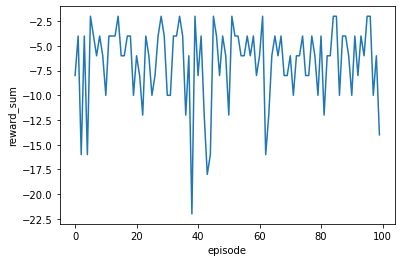

In [11]:
sns.lineplot(x=agg_samples.episode, y=agg_samples.reward_sum)

In [7]:
dh = DataHandler()

In [10]:
dh.get_all_component_failure_pairs()

[['Authentication Service', 'CF1'],
 ['Authentication Service', 'CF2'],
 ['Authentication Service', 'CF3'],
 ['Authentication Service', 'CF5'],
 ['Availability Item Filter', 'CF1'],
 ['Availability Item Filter', 'CF2'],
 ['Availability Item Filter', 'CF3'],
 ['Availability Item Filter', 'CF5'],
 ['Bid and Buy Service', 'CF1'],
 ['Bid and Buy Service', 'CF2'],
 ['Bid and Buy Service', 'CF3'],
 ['Bid and Buy Service', 'CF5'],
 ['Buy Now Item Filter', 'CF1'],
 ['Buy Now Item Filter', 'CF2'],
 ['Buy Now Item Filter', 'CF3'],
 ['Buy Now Item Filter', 'CF5'],
 ['Category Item Filter', 'CF1'],
 ['Category Item Filter', 'CF2'],
 ['Category Item Filter', 'CF3'],
 ['Category Item Filter', 'CF5'],
 ['Comment Item Filter', 'CF1'],
 ['Comment Item Filter', 'CF2'],
 ['Comment Item Filter', 'CF3'],
 ['Comment Item Filter', 'CF5'],
 ['Future Sales Item Filter', 'CF1'],
 ['Future Sales Item Filter', 'CF2'],
 ['Future Sales Item Filter', 'CF5'],
 ['Inventory Service', 'CF1'],
 ['Inventory Service', 'CF2